### Overview
This notebook evaluates the impact of realistic quantum noise on the Galton box output by comparing ideal and noisy simulations. Total Variation Distance (TVD) is used to quantify deviations.

### Goals
- Create a simple Hadamard quantum walk circuit.
- Run simulations on both ideal (noiseless) and noisy simulators.
- Compare the distributions using Total Variation Distance (TVD).
- Visualize the impact of noise via side-by-side plots with Gaussian and Binomial overlays.



In [1]:
# === Import standard libraries ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import warnings
warnings.filterwarnings('ignore')

import os

# Create output directory
output_dir = "../outputs/Derivable4a/"
os.makedirs(output_dir, exist_ok=True)  # Create if doesn't exist


STEP 1: Define a Simple Custom Noise Model For Demonstration Purposes

In [2]:
 # We're not using an IBM backend here, so let's manually create a basic noise model.
# We can later add depolarizing or readout errors for realism.
# -----------------------------------------------------------------------------------

# Create a basic (empty) noise model which can be manually tuned if needed.
noise_model = NoiseModel()

# Extract basis gates for compatibility during transpilation
basis_gates = noise_model.basis_gates


STEP 2: Build Hadamard Quantum Walk Circuit

In [3]:
def build_hadamard_quantum_walk(n_layers):
    """
    Constructs a basic quantum walk circuit using Hadamard gates on n qubits.
    
    Args:
        n_layers (int): Number of steps/qubits in the quantum walk.
    
    Returns:
        QuantumCircuit: Qiskit quantum circuit with Hadamard walk and measurement.
    """
    qr = QuantumRegister(n_layers, 'q')
    cr = ClassicalRegister(n_layers, 'pos')
    qc = QuantumCircuit(qr, cr)

    # Apply Hadamard gate on each qubit to create superposition
    for i in range(n_layers):
        qc.h(i)

    qc.barrier()
    qc.measure(qr, cr)
    return qc

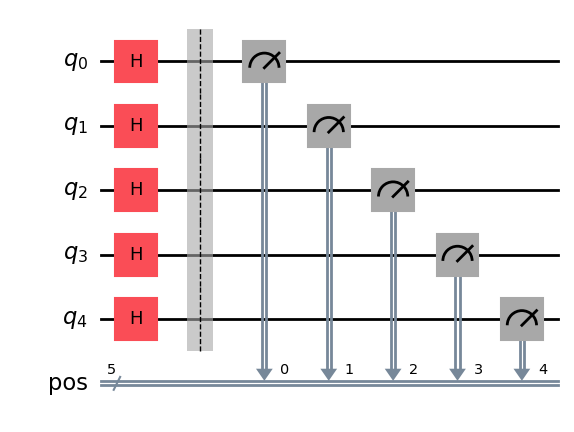

In [4]:
qc=build_hadamard_quantum_walk(5)
qc.draw('mpl')

STEP 3: Build Circuit and Simulate Both Ideal and Noisy Distributions

In [5]:
steps = 5  # Number of layers/steps in the Galton box
qc = build_hadamard_quantum_walk(steps)

# Initialize Aer simulator
simulator = AerSimulator()

# --- IDEAL simulation (no noise) ---
transpiled_ideal = transpile(qc, simulator)
result_ideal = simulator.run(transpiled_ideal, shots=8192).result()
ideal_counts = result_ideal.get_counts()

# --- NOISY simulation ---
transpiled_noisy = transpile(qc, simulator, basis_gates=basis_gates, optimization_level=3)
result_noisy = simulator.run(transpiled_noisy, noise_model=noise_model, shots=8192).result()
noisy_counts = result_noisy.get_counts()

STEP 4: Total Variation Distance Calculation

In [6]:
def total_variation_distance(counts1, counts2):
    """
    Compute the total variation distance between two discrete distributions.
    
    Args:
        counts1, counts2 (dict): Count dictionaries from Qiskit simulations.
    
    Returns:
        float: Total variation distance (0 = identical, 1 = completely different).
    """
    all_keys = set(counts1.keys()).union(counts2.keys())
    total1 = sum(counts1.values())
    total2 = sum(counts2.values())

    tvd = sum(
        abs(counts1.get(k, 0) / total1 - counts2.get(k, 0) / total2)
        for k in all_keys
    ) / 2

    return tvd

# Calculate and print TVD
tvd = total_variation_distance(ideal_counts, noisy_counts)
print(f"[✓] Total Variation Distance between ideal and noisy outputs: {tvd:.4f}")

[✓] Total Variation Distance between ideal and noisy outputs: 0.0416


STEP 5: Utilities to Convert Bitstrings and Plots

In [7]:
def counts_to_sorted_arrays(counts):
    """
    Converts Qiskit bitstring counts to sorted arrays of decimal positions and frequencies.
    
    Args:
        counts (dict): Dictionary of bitstring:frequency.
    
    Returns:
        tuple (np.ndarray, np.ndarray): Sorted x-values (positions) and y-values (frequencies).
    """
    positions = [int(k, 2) for k in counts]
    frequencies = [counts[k] for k in counts]
    sorted_data = sorted(zip(positions, frequencies), key=lambda x: x[0])
    x_vals, y_vals = zip(*sorted_data)
    return np.array(x_vals), np.array(y_vals)

STEP 6: Plotting with Gaussian and Binomial Overlays

In [8]:
def plot_counts_with_overlays(counts, n_layers, shots, title="Quantum Distribution", save_path=None):
    """
    Plots a bar chart of simulated quantum distribution with Gaussian and Binomial overlays.
    
    Args:
        counts (dict): Qiskit simulation output.
        n_layers (int): Number of qubits used.
        shots (int): Total number of measurement shots.
        title (str): Title for the plot.
    """
    x, y = counts_to_sorted_arrays(counts)
    y_prob = y / shots  # Convert raw counts to probability

    # Fit normal distribution for overlay
    mu, std = norm.fit(np.repeat(x, y))

    # Generate binomial overlay
    n = 2**n_layers - 1
    p = 0.5
    binom_x = np.arange(min(x), max(x)+1)
    binom_pmf = binom.pmf(binom_x, n, p)

    plt.bar(x, y_prob, width=0.6, alpha=0.6, label="Quantum Output")
    plt.plot(np.linspace(min(x), max(x), 300),
             norm.pdf(np.linspace(min(x), max(x), 300), mu, std),
            'r--', label=f'Gaussian Fit\nμ={mu:.2f}, σ={std:.2f}')
    plt.plot(binom_x, binom_pmf, 'g:', marker='o', label=f'Binomial\nn={n}, p={p}')
    plt.xlabel("Decimal Output (Position)")
    plt.ylabel("Probability")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show

STEP 7: Plots for Comparing Ideal Vs. Noisy Outputs

In [9]:
def plot_ideal_vs_noisy_with_overlays(ideal_counts, noisy_counts, n_layers, shots, save_path=None):
    """
    Generates side-by-side comparison plots between ideal and noisy simulations.
    
    Args:
        ideal_counts (dict): Ideal simulation results.
        noisy_counts (dict): Noisy simulation results.
        n_layers (int): Number of steps/qubits used.
        shots (int): Number of shots for measurement.
    """
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plot_counts_with_overlays(ideal_counts, n_layers, shots, title="Ideal (Noiseless)")

    plt.subplot(1, 2, 2)
    plot_counts_with_overlays(noisy_counts, n_layers, shots, title="Noisy (Custom Noise)")

    plt.suptitle("Comparison of Ideal vs Noisy Quantum Walk Distributions", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # save_path = "/home/sarojray/Downloads/womanium2025/QuantumGaltonBox/results/ideal_vs_noisy_quantum_walk_istributions.png"
    # plt.savefig(save_path, dpi=300)
    # plt.show()
    # print(f"[✓] Plot saved to: {save_path}")
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show

STEP 8: Final Execution

[✓] Plot saved to: ../outputs/Derivable4a/ideal_vs_noisy_quantum_walk_istributions.png


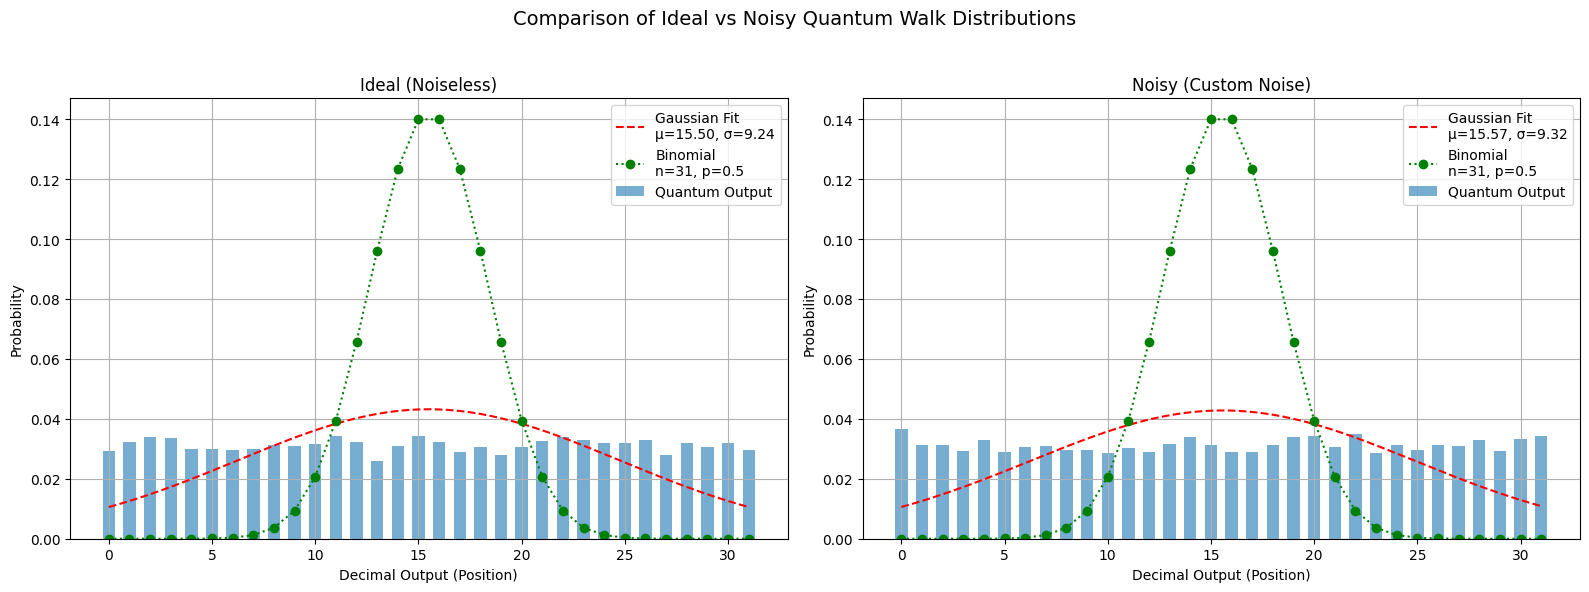

In [10]:
#Save and show the distribution plot
plot_path = os.path.join(output_dir, "ideal_vs_noisy_quantum_walk_istributions.png")
print(f"[✓] Plot saved to: {plot_path}")
plot_ideal_vs_noisy_with_overlays(ideal_counts, noisy_counts, steps, 8192)